# ATO after TNFa treatment data (for Type I Innate T cell population comparison with pan fetal reference and ATO before)

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import sys 
import celltypist
from celltypist import models
import time
import scrublet
from scipy.spatial import distance
from scipy.sparse import csr_matrix

In [2]:
# THIS IS SAMPLE 6180STDY13657795 WITH CITE-SEQ 6180STDY13657796 -Kolf

In [3]:
# Run before souporcell 
def initial_raw_data_preprocessing(sanger_sample_id, write_barcode_file):
    print('Sanger sample id: ' , sanger_sample_id)
   # path = RAW_DATA_PATH + 'ATO_sample_raw_count_matrices/' +'raw_feature_bc_matrix_' + sanger_sample_id +'/'
    path = '../irods_test/ATO_sample_raw_count_matrices/raw_feature_bc_matrix_6180STDY13657796/'
    print(path)
    
    adata = sc.read(path+'matrix.mtx.gz',cache=True).transpose()
    adata.var_names = np.genfromtxt(path + 'features.tsv.gz',dtype=str)[:,1]
    adata.obs_names = np.genfromtxt(path + 'barcodes.tsv.gz',dtype=str)
    adata.obs['sanger_sample_id'] = np.repeat(sanger_sample_id,adata.shape[0])
    # adata = sc.read_10x_h5(sample_raw_count_matrix_file) # this misses antibody hashtags specific features
    adata.var_names_make_unique()
    print('Raw size: ',adata.shape) # (737280, 64596)
    mito_genes = adata.var_names.str.startswith('GRCh38_MT-') 
    human_genes = adata.var_names.str.startswith('GRCh38') 
    mouse_genes = adata.var_names.str.startswith('mm10_') 
    
    GEX = human_genes + mouse_genes

    total_UMI_count_across_human_genes = np.sum(adata.X[:, human_genes],axis=1).A1 
    total_UMI_count_across_mito_genes = np.sum(adata.X[:, mito_genes],axis=1).A1
    total_UMI_count_across_genes = np.sum(adata.X[:, GEX],axis=1).A1  # the total UMI count for each cell across all genes
    n_genes_expressed = np.sum(adata[:,GEX].X>0,axis=1).A1  # the # of genes that are expressed (UMI!=0)
    adata.obs['percent_total_human_UMI'] = np.nan_to_num(np.divide(total_UMI_count_across_human_genes,total_UMI_count_across_genes)) 
    adata.obs['percent_total_mito_UMI']= np.nan_to_num(np.divide(total_UMI_count_across_mito_genes,total_UMI_count_across_genes))
    adata.obs['human_cells'] = adata.obs['percent_total_human_UMI']>0.9
    adata.obs['total_UMI_count_across_genes'] = total_UMI_count_across_genes
    adata.obs['n_genes_expressed'] = n_genes_expressed 

    print('Filtering cells')
    adata = adata[adata.obs['percent_total_human_UMI']>0.9]  #If >90% reads are from human genes then they are called human_cells
    adata = adata[adata.obs['total_UMI_count_across_genes'] > 2000]
    adata = adata[adata.obs['n_genes_expressed'] > 500] # sc.pp.filter_cells(adata_check, min_genes=500)
    adata = adata[adata.obs['n_genes_expressed'] < 7000] # sc.pp.filter_cells(adata_check, max_genes=7000)
    adata = adata[adata.obs['percent_total_mito_UMI']<0.1] # sc.pp.filter_cells(adata_check, min_counts=2000) 
    
    return adata

adata = initial_raw_data_preprocessing('6180STDY13657796', write_barcode_file=False)
adata = adata[:,~adata.var_names.str.startswith('mm10')] # remove mouse genes
samples = [adata]
# This is T23_Kolf_TNF_wk7 batch

Sanger sample id:  6180STDY13657796
../irods_test/ATO_sample_raw_count_matrices/raw_feature_bc_matrix_6180STDY13657796/
Raw size:  (737280, 64595)
Filtering cells


In [4]:
adata

View of AnnData object with n_obs × n_vars = 174 × 33542
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed'

4.990012897178531


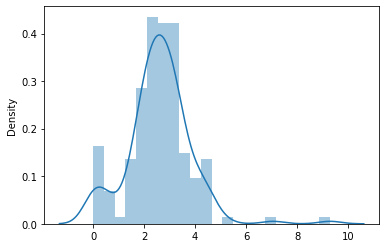

In [4]:
if(False):
    # ONE TIME CHECK ---- deciding the mito % threshold for cell filtering based on IQR outliers
    sample_mito_thresholds = []
    all_samples_mito_percentages = [] 
    for i in range(len(samples)):
        all_samples_mito_percentages = all_samples_mito_percentages + list(samples[i].obs.percent_total_mito_UMI)
        #sb.distplot(np.asarray(samples[i].obs.percent_total_mito_UMI)*100)
        Q1,Q3 = np.percentile(samples[i].obs.percent_total_mito_UMI,[25,75])
        IQR = Q3-Q1
        U = Q3 + (1.5*IQR)
        sample_mito_thresholds.append(U)
    #Across all samples, mito read % distribution
    sb.distplot(np.asarray(all_samples_mito_percentages)*100) 
    Q1,Q3 = np.percentile(all_samples_mito_percentages,[25,75])
    IQR = Q3-Q1
    U = Q3 + (1.5*IQR)
    print(U*100)
    # we will not filter because all cells have low percentage < 10%

In [5]:
Antibody_capture = adata.var_names[~adata.var_names.str.startswith(('GRCh38'))]
adata.obs['Antibody_max_perc'] = np.max(adata[:,Antibody_capture].X, axis=1) / np.sum(adata[:,Antibody_capture].X, axis=1)

Trying to set attribute `.obs` of view, copying.


In [6]:
temp = []
for i in range(adata.shape[0]):
    if(np.all(adata[i,Antibody_capture].X.todense()==0)):
        temp.append(str(np.NaN))
    else:
        temp.append(Antibody_capture[np.argmax(np.array(adata[i,Antibody_capture].X.todense()),axis=1)][0]) 
adata.obs['Antibody_calling'] = np.asarray(temp)
np.unique(adata.obs['Antibody_calling'], return_counts=True)

adata.obs.loc[adata.obs['Antibody_max_perc'] < 0.5,'Antibody_calling'] = np.nan
# The separate cell lines identified by different antibody tags
adata.var_names[~adata.var_names.str.startswith(('GRCh38'))]
adata = adata[:,adata.var_names.str.startswith(('GRCh38'))]

In [7]:
np.min(adata.obs['Antibody_max_perc']) 

0.7417582

In [8]:
np.unique(adata.obs['Antibody_calling'], return_counts=True)

(array(['Kolf_TNF1ng', 'Kolf_TNF25ng', 'Kolf_WT'], dtype=object),
 array([152,   8,  14]))

In [9]:
pd.Series(adata.obs.Antibody_calling).unique()

array(['Kolf_TNF25ng', 'Kolf_TNF1ng', 'Kolf_WT'], dtype=object)

In [10]:
# making variable names (gene names) compatible with common gene names e.g. <hg38_1hho> = 1hho
modified_varnames = []
for gene in adata.var_names:
    modified_varnames.append(gene[7:len(gene)])
adata.var_names = modified_varnames
adata

AnnData object with n_obs × n_vars = 174 × 33538
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'Antibody_max_perc', 'Antibody_calling'

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 4.0%
Estimated detectable doublet fraction = 18.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 22.2%
Elapsed time: 0.4 seconds


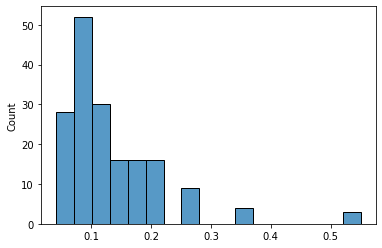

In [11]:
scrub = scrublet.Scrublet(adata.X)
scrublet_doublet_scores, scrublet_predicted_doublets = scrub.scrub_doublets()
sb.histplot(scrublet_doublet_scores)
adata.obs['scrublet_doublet_scores'] = scrublet_doublet_scores
adata.obs['scrublet_predicted_doublets'] = scrublet_predicted_doublets

In [12]:
adata.X.data

array([ 1.,  2.,  1., ..., 10.,  5., 42.], dtype=float32)

In [13]:
adata

AnnData object with n_obs × n_vars = 174 × 33538
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'Antibody_max_perc', 'Antibody_calling', 'scrublet_doublet_scores', 'scrublet_predicted_doublets'

In [14]:
#adata = anndata.read_h5ad('ATO_TNF.h5ad')
# filtering doublets
CUTOFF = 0.15
adata = adata[adata.obs['scrublet_doublet_scores']<CUTOFF] 

#adata.write_h5ad('ATO_TNF.h5ad', compression='gzip')

# Preprocessing new data

In [15]:
adata

View of AnnData object with n_obs × n_vars = 126 × 33538
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'Antibody_max_perc', 'Antibody_calling', 'scrublet_doublet_scores', 'scrublet_predicted_doublets'

In [16]:
np.unique(adata.obs['Antibody_calling'], return_counts=True)

(array(['Kolf_TNF1ng', 'Kolf_TNF25ng', 'Kolf_WT'], dtype=object),
 array([119,   6,   1]))

In [17]:
adata.X.data

array([ 1.,  2.,  1., ..., 32.,  6., 33.], dtype=float32)

In [18]:
adata.raw = adata.copy() # storing raw counts before filtering genes
adata.raw.shape

(126, 33538)

In [19]:
adata.X.data

array([ 1.,  2.,  1., ..., 32.,  6., 33.], dtype=float32)

In [20]:
adata_original = adata.copy() 

In [21]:
adata_original.X.data

array([ 1.,  2.,  1., ..., 32.,  6., 33.], dtype=float32)

In [22]:
#adata.raw.to_adata()

In [23]:
#temp_adata = adata.raw.to_adata()
#temp_adata.layers['counts'] = temp_adata.X
#adata_bck = adata.copy()
#adata = temp_adata.copy()
adata = adata_original.copy() 
sc.pp.normalize_per_cell(adata, 10000) 
sc.pp.log1p(adata)

In [24]:
adata.X.data

array([0.8220613, 1.2670517, 0.8220613, ..., 2.981801 , 1.5064346,
       3.011035 ], dtype=float32)

In [25]:
import celltypist
np.random.seed(3)
run_celltypist = True
if(run_celltypist):
    predictions = celltypist.annotate(adata, model = 'Pan_Fetal_Human.pkl',majority_voting=True)
    predictions_high_level = celltypist.annotate(adata, model = "Immune_Thymus_High.pkl", majority_voting=True)
    predictions_low_level = celltypist.annotate(adata, model = "Immune_Thymus_Low.pkl", majority_voting=True)
    adata.obs['celltypist_panfetal_predictions'] = predictions.predicted_labels['majority_voting']
    adata.obs['celltypist_high_level_predictions'] = predictions_high_level.predicted_labels['majority_voting']
    adata.obs['celltypist_low_level_predictions'] = predictions_low_level.predicted_labels['majority_voting']
    
    high_level_predictions = []
    for i in range(0,adata.shape[0]):
        annotation = adata.obs['celltypist_panfetal_predictions'][i]
        if(annotation.startswith('DP')):
            high_level_predictions.append('DP')
        elif(annotation.startswith('DN')):
            high_level_predictions.append('DN')      
        elif(annotation.startswith('MONOCYTE')):
            high_level_predictions.append('MONOCYTE')   
        elif(annotation.endswith('INNATE_T')):
            high_level_predictions.append('INNATE_T') 
        elif(annotation.endswith('_MK')):
            high_level_predictions.append('MK') 
        elif(annotation.endswith('_MPP')):
            high_level_predictions.append('MPP') 
        elif(annotation.endswith('_MEMP')):
            high_level_predictions.append('MEMP') 
        elif(annotation.endswith('_NK')):
            high_level_predictions.append('NK') 
        else:
            high_level_predictions.append(annotation)
    adata.obs['celltypist_panfetal_predictions_high_level'] = high_level_predictions

🔬 Input data has 126 cells and 33538 genes
🔗 Matching reference genes in the model
🧬 6527 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 126 cells and 33538 genes
🔗 Matching reference genes in the model
🧬 3800 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 126 cells and 33538 genes
🔗 Matching reference genes in the model
🧬 4911 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object,

In [26]:
adata.X.data

array([0.8220613, 1.2670517, 0.8220613, ..., 2.981801 , 1.5064346,
       3.011035 ], dtype=float32)

In [32]:
#adata_bck.obs['celltypist_panfetal_predictions'] = adata.obs.celltypist_panfetal_predictions
#adata_bck.obs['celltypist_high_level_predictions'] = adata.obs.celltypist_high_level_predictions
#adata_bck.obs['celltypist_low_level_predictions'] = adata.obs.celltypist_low_level_predictions
#adata_bck.obs['celltypist_panfetal_predictions_high_level'] = adata.obs.celltypist_panfetal_predictions_high_level
#adata = adata_bck.copy() 

In [27]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

... storing 'sanger_sample_id' as categorical
... storing 'Antibody_calling' as categorical
... storing 'celltypist_panfetal_predictions_high_level' as categorical


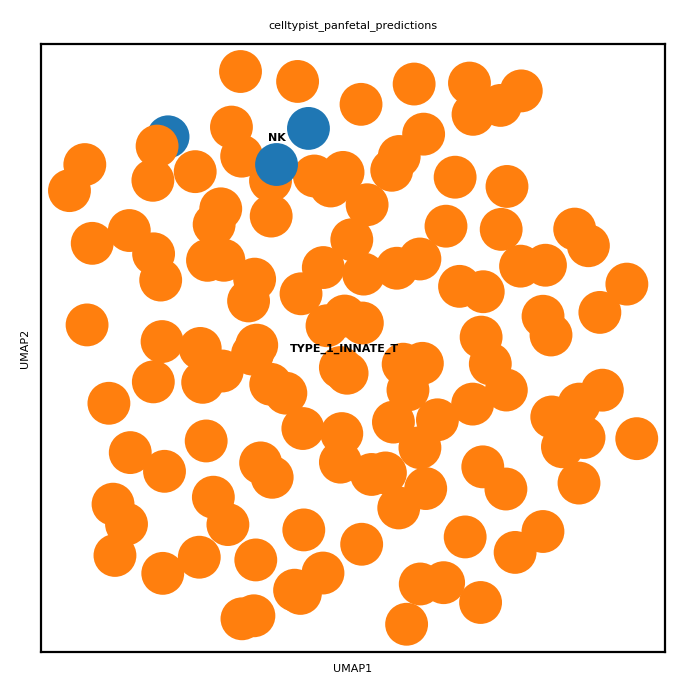

In [28]:
sc.set_figure_params(fontsize=4, dpi=200)
sc.pl.umap(adata,color=['celltypist_panfetal_predictions'],legend_loc='on data')

In [30]:
#126 cells
# 4 cells predicted as NK cells
# Only 1 WT and 6 25ng cells, no 5ng cells


np.unique(adata.obs.Antibody_calling, return_counts=True)
pd.crosstab(adata.obs.Antibody_calling, adata.obs.celltypist_panfetal_predictions)

celltypist_panfetal_predictions,NK,TYPE_1_INNATE_T
Antibody_calling,,
Kolf_TNF1ng,3,116
Kolf_TNF25ng,0,6
Kolf_WT,0,1


In [31]:
adata[adata.obs.celltypist_panfetal_predictions == 'TYPE_1_INNATE_T'] 

View of AnnData object with n_obs × n_vars = 123 × 33538
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'Antibody_max_perc', 'Antibody_calling', 'scrublet_doublet_scores', 'scrublet_predicted_doublets', 'n_counts', 'celltypist_panfetal_predictions', 'celltypist_high_level_predictions', 'celltypist_low_level_predictions', 'celltypist_panfetal_predictions_high_level', 'leiden'
    uns: 'log1p', 'neighbors', 'leiden', 'umap', 'celltypist_panfetal_predictions_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [32]:
a = adata[adata.obs.celltypist_panfetal_predictions!='TYPE_1_INNATE_T'] 
b = adata[adata.obs.celltypist_panfetal_predictions=='TYPE_1_INNATE_T'] 

In [33]:
a

View of AnnData object with n_obs × n_vars = 3 × 33538
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'Antibody_max_perc', 'Antibody_calling', 'scrublet_doublet_scores', 'scrublet_predicted_doublets', 'n_counts', 'celltypist_panfetal_predictions', 'celltypist_high_level_predictions', 'celltypist_low_level_predictions', 'celltypist_panfetal_predictions_high_level', 'leiden'
    uns: 'log1p', 'neighbors', 'leiden', 'umap', 'celltypist_panfetal_predictions_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [34]:
b

View of AnnData object with n_obs × n_vars = 123 × 33538
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'Antibody_max_perc', 'Antibody_calling', 'scrublet_doublet_scores', 'scrublet_predicted_doublets', 'n_counts', 'celltypist_panfetal_predictions', 'celltypist_high_level_predictions', 'celltypist_low_level_predictions', 'celltypist_panfetal_predictions_high_level', 'leiden'
    uns: 'log1p', 'neighbors', 'leiden', 'umap', 'celltypist_panfetal_predictions_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [35]:
adata.write_h5ad('ATO_TNF_celltypist_updated.h5ad')